In [67]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transformst
import torchvision.transforms as transforms

## Implementación de la clasiﬁcación multiclase de imágenes con Bayes ingenuo usando histogramas

Para el presente ejercicio, se implementará la clasiﬁcación de imagenes
naturales con K = 10 clases. La Figura 1 muestra algunas observaciones
del conjunto de datos. El objetivo de su equipo de desarrollo es utili-
zar el teorema de Bayes para construir un modelo conocido como Bayes
ingenuo, el cual permita estimar la clase a la que pertenece una nueva
observación



In [68]:
def load_cifar10_dataset(is_train=True):
  # Define a transformation to convert images to grayscale
  transforms_1 = transforms.Compose([
      transforms.ToTensor(),
      transforms.Grayscale(num_output_channels=1)  # Convert to grayscale
  ])
  cifar_trainset = datasets.CIFAR10(
      root='./data', train=is_train, download=True, transform=transforms_1)

  # Initialize an empty list to store batches
  all_data = []
  train_loader = torch.utils.data.DataLoader(
      cifar_trainset, batch_size=64, shuffle=True)
  # Iterate over the train_loader to fetch all batches
  for batch in train_loader:
      images, _ = batch  # Extract images from the batch
      all_data.append(images)

  # Concatenate all batches into a single tensor along the batch dimension
  cifar_trainset_tensor = torch.round(torch.cat(all_data, dim=0) * 255)
  cifar_labels = torch.tensor(cifar_trainset.targets)
  print("cifar_trainset_tensor shape ", cifar_trainset_tensor.shape)
  print("cifar_labels ", cifar_labels.shape)
  return (cifar_trainset_tensor, cifar_labels)


train_tensor, labels = load_cifar10_dataset()


train_tensor[1][0]

Files already downloaded and verified
cifar_trainset_tensor shape  torch.Size([50000, 1, 32, 32])
cifar_labels  torch.Size([50000])


tensor([[250., 249., 252.,  ..., 223., 221., 218.],
        [247., 249., 250.,  ..., 227., 226., 225.],
        [241., 242., 244.,  ..., 232., 233., 234.],
        ...,
        [126., 122., 126.,  ..., 113., 118., 116.],
        [138., 133., 132.,  ..., 116., 120., 121.],
        [138., 134., 136.,  ..., 134., 135., 135.]])

In [69]:
train_tensor.shape

torch.Size([50000, 1, 32, 32])

In [70]:
labels.shape

torch.Size([50000])

torch.Size([32, 32])


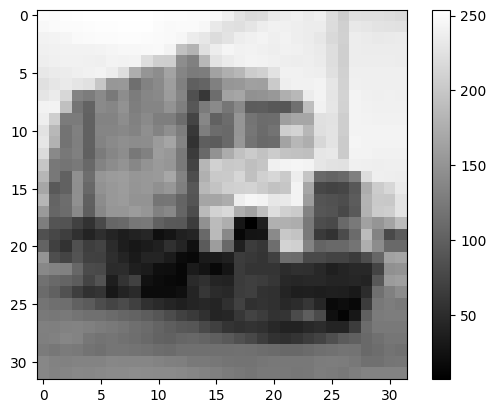

In [71]:
import matplotlib.pyplot as plt
import torch

# Assuming train_tensor[1][0] is your grayscale image tensor
image_tensor = train_tensor[1][0]

print(image_tensor.shape)

# Check if the tensor is on a CUDA device and move it to CPU
if image_tensor.is_cuda:
    image_tensor = image_tensor.cpu()

# Convert the tensor to a numpy array
image_numpy = image_tensor.numpy()

# Since it's grayscale, squeeze out the channel dimension if it exists
if image_tensor.dim() > 2:
    image_numpy = image_numpy.squeeze(0)

# Plot the image
plt.imshow(image_numpy, cmap='gray')
plt.colorbar()  # Optional, it adds a color bar to the side
plt.show()

In [72]:
image_tensor = train_tensor
image_labels = labels

Implemente el cálculo de las probabilidades a priori p (t)
para las K = 10 clases en el conjunto de datos de entrenamiento en
la función calcular_probabilidad_priori. Realice tal calculo dentro de la
funcion train_model.

In [82]:
import torch


def calculate_priori_p_t(labels):
    # Convert labels to a tensor if it's not already
    labels_tensor = torch.tensor(labels) if not isinstance(
        labels, torch.Tensor) else labels

    # Count the occurrences of each label
    label_counts = labels_tensor.bincount()

    # Compute probabilities by dividing by the total number of labels
    probabilities = label_counts.float() / labels_tensor.size(0)

    # Generate a tensor of unique labels sorted
    unique_labels = torch.arange(label_counts.size(0))

    # Filter out labels with zero count
    nonzero_indices = label_counts.nonzero().squeeze()
    probabilities = probabilities[nonzero_indices]
    unique_labels = unique_labels[nonzero_indices]

    return probabilities, unique_labels


probabilities, unique_labels = calculate_priori_p_t(labels)

print("Probabilities:", probabilities)
print("Unique labels:", unique_labels)
print("Sum of probabilities:", probabilities.sum())
print("Shape of probabilities:", probabilities.shape)

Probabilities: tensor([0.3327, 0.3364, 0.3310])
Unique labels: tensor([0, 1, 2])
Sum of probabilities: tensor(1.)
Shape of probabilities: torch.Size([3])


In [74]:
def calculate_marginal_probabilities(data, dim=0):
    # Calculate the marginal probabilities
    marginal_probabilities = data[dim].sum() / data.sum()
    return marginal_probabilities

In [75]:
Mock_data = torch.Tensor([[20.0, 70.0, 80.0, 10.0], [40.0, 10.0, 30.0, 5.0]])

print(calculate_marginal_probabilities(Mock_data, dim=0))
print(calculate_marginal_probabilities(Mock_data, dim=1))


tensor(0.6792)
tensor(0.3208)


In [76]:
def calculate_conditional_probabilities(data):
    # Calculate the conditional probabilities
    n_classes = data.shape[0]

    p_tensor = torch.zeros(data.shape)

    for i in range(n_classes):
        row_sum = data[i].sum()
        p_tensor[i] = data[i] / row_sum

    return p_tensor

p_tensor = calculate_conditional_probabilities(Mock_data)

print("Probabilities for class 0: ", p_tensor[0])
print("Probabilities for class 1: ", p_tensor[1])


Probabilities for class 0:  tensor([0.1111, 0.3889, 0.4444, 0.0556])
Probabilities for class 1:  tensor([0.4706, 0.1176, 0.3529, 0.0588])


In [77]:
import torch

# Example tensor initialization (randomly for demonstration; replace with your actual data)
# Let's assume N=100 images of size 32x32
N, C, H, W = 100, 1, 32, 32
images = torch.randint(0, 256, (N, C, H, W), dtype=torch.uint8)

# Check if pixels are 255
is_value_255 = (images == 255).float()  # Convert boolean to float for summing

# Sum across the batch dimension
pixel_255_count = is_value_255.sum(dim=0)

# Calculate probability
probability_matrix = pixel_255_count / N

print(probability_matrix.shape)  # Should be [1, 250, 250] for grayscale
print(probability_matrix[0])        # This is your result matrix

torch.Size([1, 32, 32])
tensor([[0.0100, 0.0200, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0100, 0.0000,  ..., 0.0000, 0.0000, 0.0100],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0100, 0.0000,  ..., 0.0100, 0.0000, 0.0000]])


In [78]:
import torch

# Example tensor initialization (randomly for demonstration; replace with your actual data)
# Let's assume N=100 images of size 250x250
N, C, H, W = 100, 1, 250, 250
images = torch.randint(0, 256, (N, C, H, W), dtype=torch.uint8)

# Check if pixels are 255
is_value_255 = (images == 255).float()  # Convert boolean to float for summing

# Sum across the batch dimension
pixel_255_count = is_value_255.sum(dim=0)

# Calculate probability
probability_matrix = pixel_255_count / N

# Flatten the 2D probability matrix to a 1D array
probability_array = probability_matrix.flatten()

print(probability_array.shape)  # Should be [62500] for a 250x250 image
print(probability_array)        # This is your result array

torch.Size([62500])
tensor([0.0000, 0.0000, 0.0100,  ..., 0.0000, 0.0000, 0.0100])


In [79]:
import torch


def calculate_probability_matrix(images, normalize=False):
    min_pixel_value = int(images.min().item())
    max_pixel_value = int(images.max().item())
    num_pixel_values = max_pixel_value - \
        min_pixel_value + 1  # +1 because range is inclusive

    H, W = images.shape[2], images.shape[3]
    images_flattened = images.view(-1, H*W)

    pixel_value_counts = torch.zeros(
        (num_pixel_values, H*W), dtype=torch.float32)

    # Count occurrences of each pixel value for each pixel position
    for idx in range(H*W):
        pixel_values = images_flattened[:, idx]
        hist = torch.histc(pixel_values.float(), bins=num_pixel_values,
                           min=min_pixel_value, max=max_pixel_value)
        pixel_value_counts[:, idx] = hist

    probability_matrix = pixel_value_counts / images.shape[0]

    if normalize:
        # Normalize such that the sum of probabilities for each pixel value across all positions is 1
        probability_matrix = probability_matrix / \
            probability_matrix.sum(dim=1, keepdim=True)

    return probability_matrix.view(num_pixel_values, H, W)


def calculate_class_probabilities(train_data, labels, num_classes=3, normalize=False):
    class_probabilities = []

    for class_id in range(num_classes):
        class_indices = torch.where(labels == class_id)[0]
        class_images = train_data[class_indices]
        probability_matrix = calculate_probability_matrix(
            class_images, normalize=normalize)
        class_probabilities.append(probability_matrix)

    final_probability_tensor = torch.stack(class_probabilities, dim=0)
    return final_probability_tensor


# Example usage
train_data = torch.randint(0, 256, (50000, 1, 32, 32), dtype=torch.uint8)
labels = torch.randint(0, 3, (50000,), dtype=torch.long)
final_probability_tensor = calculate_class_probabilities(
    train_data, labels, normalize=True)

print(final_probability_tensor.shape)  # Should be [3, 256, 32, 32]
print(final_probability_tensor)        # This is your result tensor
# The result will be 1 if normalization is done correctly
print(final_probability_tensor[0][0].sum())  # Should now correctly return 1

torch.Size([3, 256, 32, 32])
tensor([[[[0.0011, 0.0009, 0.0011,  ..., 0.0010, 0.0009, 0.0009],
          [0.0010, 0.0011, 0.0008,  ..., 0.0010, 0.0012, 0.0009],
          [0.0010, 0.0008, 0.0011,  ..., 0.0011, 0.0010, 0.0010],
          ...,
          [0.0010, 0.0009, 0.0009,  ..., 0.0010, 0.0010, 0.0009],
          [0.0012, 0.0009, 0.0009,  ..., 0.0010, 0.0009, 0.0012],
          [0.0009, 0.0012, 0.0008,  ..., 0.0009, 0.0009, 0.0011]],

         [[0.0008, 0.0010, 0.0011,  ..., 0.0009, 0.0009, 0.0010],
          [0.0012, 0.0008, 0.0008,  ..., 0.0009, 0.0011, 0.0009],
          [0.0010, 0.0012, 0.0009,  ..., 0.0012, 0.0013, 0.0011],
          ...,
          [0.0011, 0.0009, 0.0006,  ..., 0.0010, 0.0008, 0.0009],
          [0.0009, 0.0008, 0.0010,  ..., 0.0009, 0.0012, 0.0009],
          [0.0007, 0.0010, 0.0011,  ..., 0.0010, 0.0011, 0.0011]],

         [[0.0011, 0.0011, 0.0009,  ..., 0.0010, 0.0009, 0.0013],
          [0.0006, 0.0009, 0.0009,  ..., 0.0010, 0.0009, 0.0009],
          [0.

In [80]:
print(final_probability_tensor[0][0].sum())

tensor(1.0000)


In [81]:
final_probability_tensor = calculate_class_probabilities(image_tensor, image_labels, num_classes=10, normalize=True)

print(final_probability_tensor.shape)  # Should be [3, 256, 1024]
print(final_probability_tensor)
print(final_probability_tensor[0][0].sum())        # This is your result tensor

torch.Size([10, 256, 32, 32])
tensor([[[[0.0030, 0.0027, 0.0026,  ..., 0.0024, 0.0026, 0.0032],
          [0.0026, 0.0030, 0.0027,  ..., 0.0027, 0.0024, 0.0027],
          [0.0024, 0.0024, 0.0029,  ..., 0.0021, 0.0023, 0.0021],
          ...,
          [0.0009, 0.0008, 0.0012,  ..., 0.0015, 0.0017, 0.0015],
          [0.0008, 0.0008, 0.0014,  ..., 0.0014, 0.0015, 0.0012],
          [0.0014, 0.0014, 0.0014,  ..., 0.0018, 0.0018, 0.0018]],

         [[0.0029, 0.0024, 0.0021,  ..., 0.0022, 0.0020, 0.0021],
          [0.0029, 0.0030, 0.0022,  ..., 0.0017, 0.0019, 0.0019],
          [0.0028, 0.0028, 0.0021,  ..., 0.0017, 0.0018, 0.0021],
          ...,
          [0.0012, 0.0014, 0.0015,  ..., 0.0011, 0.0014, 0.0014],
          [0.0017, 0.0019, 0.0021,  ..., 0.0012, 0.0017, 0.0020],
          [0.0023, 0.0020, 0.0019,  ..., 0.0012, 0.0014, 0.0018]],

         [[0.0020, 0.0024, 0.0030,  ..., 0.0017, 0.0024, 0.0024],
          [0.0017, 0.0014, 0.0023,  ..., 0.0020, 0.0021, 0.0028],
          [0